# Imports


In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
#import squarify
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load Dataset

In [2]:
# # Install dependencies if needed:
# # pip install kagglehub[pandas-datasets]

# import kagglehub
# from kagglehub import KaggleDatasetAdapter
# import pandas as pd

# # Specify the CSV file you want from the dataset
# file_path = "2019-Oct.csv"  # You can change to another file, like '2019-Nov.csv'

# # Load only the first 1,000,000 rows using pandas_kwargs
# df = kagglehub.load_dataset(
#     KaggleDatasetAdapter.PANDAS,
#     "mkechinov/ecommerce-behavior-data-from-multi-category-store",
#     file_path,
#     pandas_kwargs={"nrows": 2000000}
# )

# # Show the first 5 records
# print("First 5 records:")
# print(df.head())


In [ ]:
# Count the total number of lines in the file
n_rows = sum(1 for line in open('2019-Oct.csv')) - 1  # subtract 1 for header
sample_size = 1_000_000

# Generate line numbers to skip (excluding the header)
skip = sorted(random.sample(range(1, n_rows + 1), n_rows - sample_size))

# Read the sampled rows
df = pd.read_csv('2019-Oct.csv', skiprows=skip)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [5]:
df.shape

(42448764, 9)

# Preprocessing


In [6]:
df.isnull().sum().sum()

19632691

In [7]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [8]:
df.duplicated().sum()

30220

In [9]:
print(df['event_type'].value_counts())
print(df['event_type'].nunique())
df['event_type'].unique().tolist()

view        40779399
cart          926516
purchase      742849
Name: event_type, dtype: int64
3


['view', 'purchase', 'cart']

In [10]:
print(df['event_type'].isnull().sum())

0


In [11]:
import pandas as pd
df = pd.get_dummies(df, columns=['event_type'], prefix='event_type')
print(df.head())

                event_time  product_id          category_id  \
0  2019-10-01 00:00:00 UTC    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  event_type_cart  event_type_purchase  \
0  72d76fde-8bb3-4e00-8c23-a032dfed738c                0                    0   
1  9333dfbd-b87a-4708-9857

In [12]:
df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,1
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,1
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,1


In [13]:
df[['event_type_cart', 'event_type_purchase', 'event_type_view']] = df[['event_type_cart', 'event_type_purchase', 'event_type_view']].astype(int)

In [14]:
df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,1
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,1
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,1


In [15]:
print(df['brand'].value_counts())
print(df['brand'].nunique())
print("___")
print(df['category_code'].value_counts())
print(df['category_code'].nunique())

samsung         5282775
apple           4122554
xiaomi          3083763
huawei          1111205
lucente          655861
                 ...   
nec                   1
neocoregames          1
incase                1
portdesigns           1
skindoctors           1
Name: brand, Length: 3444, dtype: int64
3444
___
electronics.smartphone          11507231
electronics.clocks               1311033
computers.notebook               1137623
electronics.video.tv             1113750
electronics.audio.headphone      1100188
                                  ...   
construction.tools.soldering         632
apparel.shorts                       632
apparel.jacket                       436
auto.accessories.anti_freeze         308
country_yard.furniture.bench         190
Name: category_code, Length: 126, dtype: int64
126


In [16]:
df.brand.isnull().sum()

6117080

In [17]:
df['category_code'] = df['category_code'].fillna(df['category_code'].mode()[0])
df.isnull().sum()

event_time                   0
product_id                   0
category_id                  0
category_code                0
brand                  6117080
price                        0
user_id                      0
user_session                 2
event_type_cart              0
event_type_purchase          0
event_type_view              0
dtype: int64

In [19]:
encoder = ce.BinaryEncoder(cols=['category_code'])
df_encoded = encoder.fit_transform(df[['category_code']])
df = pd.concat([df, df_encoded], axis=1)
print(df.head())

MemoryError: Unable to allocate 324. MiB for an array with shape (1, 42448764) and data type object

In [19]:
df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view,category_code_0,category_code_1,category_code_2,category_code_3,category_code_4,category_code_5,category_code_6
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,electronics.smartphone,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1,0,0,0,0,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,1,0,0,0,0,0,1,0
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,1,0,0,0,0,0,1,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,1,0,0,0,0,1,0,0
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,1,0,0,0,0,0,0,1


In [20]:
df['brand'] = df['brand'].fillna(df['brand'].mode()[0])
df.isnull().sum()

event_time             0
product_id             0
category_id            0
category_code          0
brand                  0
price                  0
user_id                0
user_session           2
event_type_cart        0
event_type_purchase    0
event_type_view        0
category_code_0        0
category_code_1        0
category_code_2        0
category_code_3        0
category_code_4        0
category_code_5        0
category_code_6        0
dtype: int64

In [21]:
encoder = ce.BinaryEncoder(cols=['brand'])
df_encoded = encoder.fit_transform(df['brand'])
df = pd.concat([df, df_encoded], axis=1)

In [22]:
df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,event_type_cart,event_type_purchase,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,electronics.smartphone,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,furniture.living_room.sofa,samsung,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,...,0,0,0,0,0,0,0,1,0,1


In [23]:
df = df.drop(['category_code', 'brand'], axis=1)

In [24]:
df.head()

,event_time,product_id,category_id,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view,category_code_0,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [25]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

if not outliers.empty:
  print("Outliers found in the 'price' column:")
  print(outliers[['price']])
else:
  print("No outliers found in the 'price' column based on the IQR method.")

Outliers found in the 'price' column:
            price
4         1081.98
5          908.62
11         900.64
19        1747.79
22         921.49
...           ...
42448662   926.41
42448667  1067.98
42448699  1091.33
42448728  1665.36
42448731  2570.18

[3671578 rows x 1 columns]


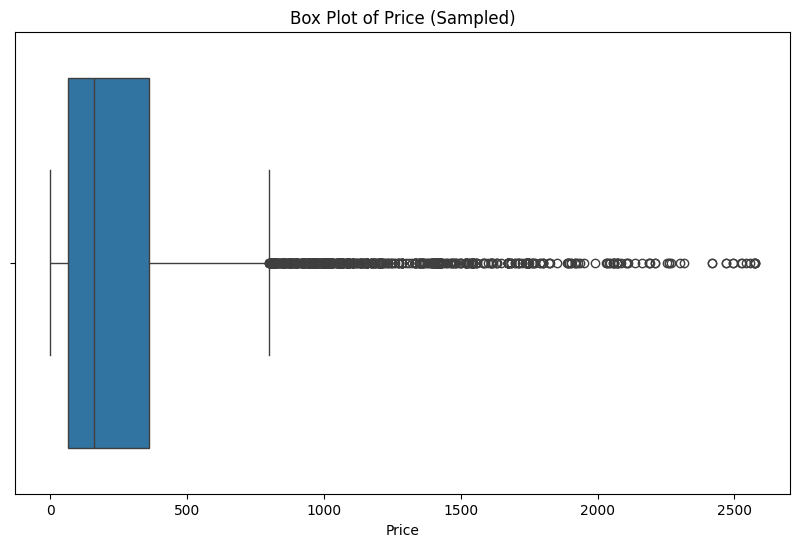

In [26]:
# Sample 10,000 rows from the dataset
sample_df = df['price'].sample(n=10000, random_state=42)

plt.figure(figsize=(10, 6))
sns.boxplot(x=sample_df)
plt.title('Box Plot of Price (Sampled)')
plt.xlabel('Price')
plt.show()

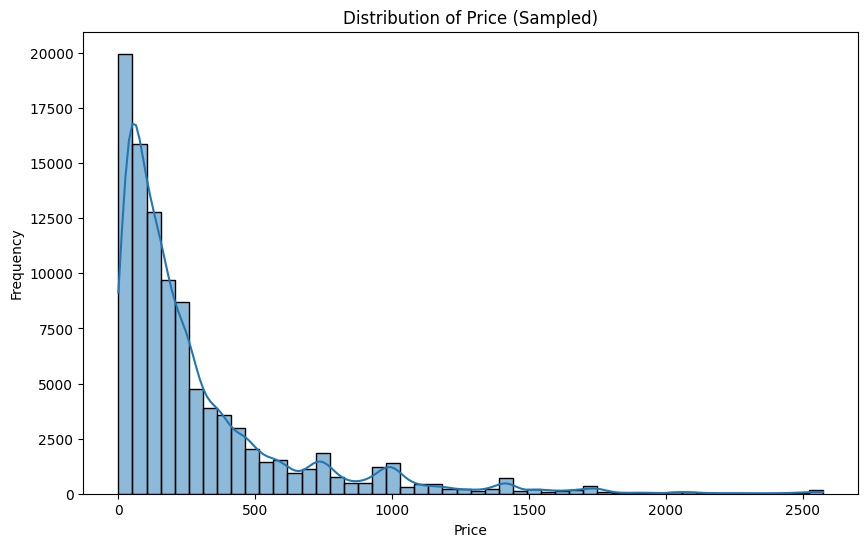

In [27]:
# Sample 100,000 rows (adjust size based on available memory)
sample = df['price'].sample(n=100000, random_state=42)

plt.figure(figsize=(10, 6))
sns.histplot(sample, kde=True, bins=50)
plt.title('Distribution of Price (Sampled)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

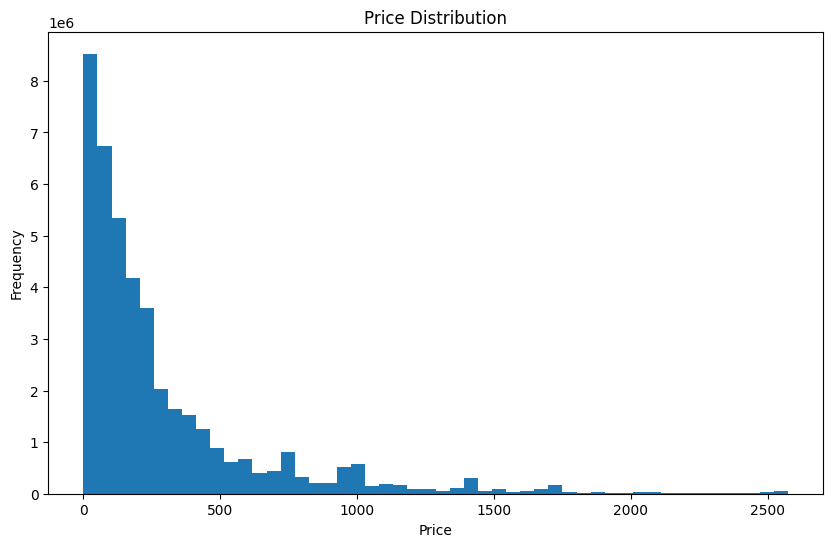

In [28]:
import numpy as np

counts, bins = np.histogram(df['price'].dropna(), bins=50)
plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['price'] = scaler.fit_transform(df[['price']])

print(df['price'].head())

0   -0.710454
1   -0.717683
2    0.705549
3   -0.107695
4    2.209669
Name: price, dtype: float64


In [30]:
df.head()

,event_time,product_id,category_id,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view,category_code_0,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,-0.710454,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,-0.717683,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,0.705549,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,-0.107695,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,2.209669,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [31]:
df.head()

,event_time,product_id,category_id,price,user_id,user_session,event_type_cart,event_type_purchase,event_type_view,category_code_0,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:00:00 UTC,44600062,2103807459595387724,-0.710454,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:00:00 UTC,3900821,2053013552326770905,-0.717683,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:00:01 UTC,17200506,2053013559792632471,0.705549,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,2019-10-01 00:00:01 UTC,1307067,2053013558920217191,-0.107695,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,2019-10-01 00:00:04 UTC,1004237,2053013555631882655,2.209669,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   event_time           object 
 1   product_id           int64  
 2   category_id          int64  
 3   price                float64
 4   user_id              int64  
 5   user_session         object 
 6   event_type_cart      int64  
 7   event_type_purchase  int64  
 8   event_type_view      int64  
 9   category_code_0      int64  
 10  category_code_1      int64  
 11  category_code_2      int64  
 12  category_code_3      int64  
 13  category_code_4      int64  
 14  category_code_5      int64  
 15  category_code_6      int64  
 16  brand_0              int64  
 17  brand_1              int64  
 18  brand_2              int64  
 19  brand_3              int64  
 20  brand_4              int64  
 21  brand_5              int64  
 22  brand_6              int64  
 23  brand_7              int64  
 

In [33]:
df.shape

(42448764, 28)

In [34]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)

In [35]:
df['event_time']

0          2019-10-01 00:00:00+00:00
1          2019-10-01 00:00:00+00:00
2          2019-10-01 00:00:01+00:00
3          2019-10-01 00:00:01+00:00
4          2019-10-01 00:00:04+00:00
                      ...           
42448759   2019-10-31 23:59:58+00:00
42448760   2019-10-31 23:59:58+00:00
42448761   2019-10-31 23:59:58+00:00
42448762   2019-10-31 23:59:59+00:00
42448763   2019-10-31 23:59:59+00:00
Name: event_time, Length: 42448764, dtype: datetime64[ns, UTC]

In [36]:
df.dtypes

event_time             datetime64[ns, UTC]
product_id                           int64
category_id                          int64
price                              float64
user_id                              int64
user_session                        object
event_type_cart                      int64
event_type_purchase                  int64
event_type_view                      int64
category_code_0                      int64
category_code_1                      int64
category_code_2                      int64
category_code_3                      int64
category_code_4                      int64
category_code_5                      int64
category_code_6                      int64
brand_0                              int64
brand_1                              int64
brand_2                              int64
brand_3                              int64
brand_4                              int64
brand_5                              int64
brand_6                              int64
brand_7    

In [70]:
df.set_index('event_time', inplace=True)

KeyError: "None of ['event_time'] are in the columns"

In [69]:
# Take a random sample of 1 million rows (preserving index)
df_sample = df.sample(n=1_000_000, random_state=42)

# Ensure the index is datetime
df_sample.index = pd.to_datetime(df_sample.index, utc=True)

# Resample by day and count events
daily_events = df_sample.resample('D').size()

MemoryError: Unable to allocate 162. MiB for an array with shape (42448764,) and data type int32

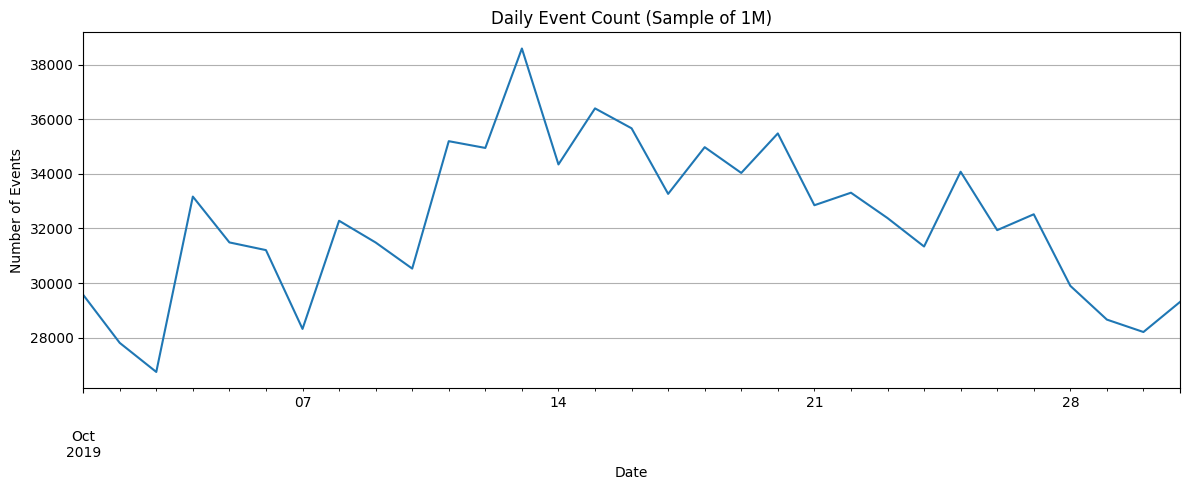

In [45]:
# Plot the result
plt.figure(figsize=(12, 5))
daily_events.plot(title='Daily Event Count (Sample of 1M)')
plt.ylabel('Number of Events')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

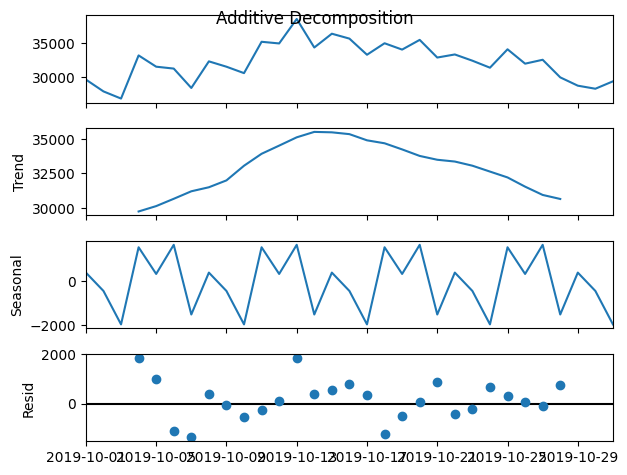

In [47]:
# Additive decomposition
result_add = seasonal_decompose(daily_events, model='additive', period=7)  # period=7 for weekly seasonality
result_add.plot()
plt.suptitle('Additive Decomposition')
plt.show()

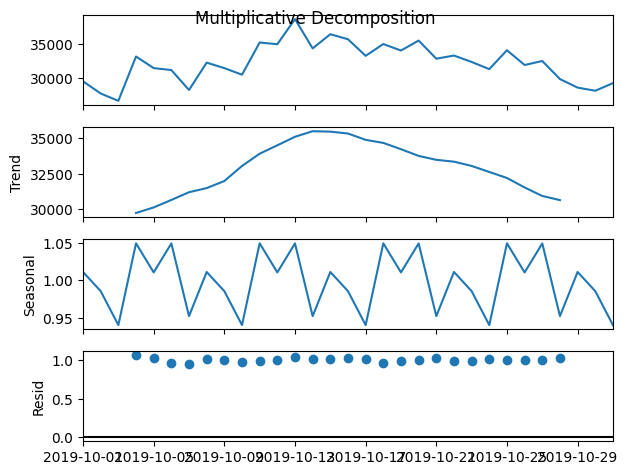

In [48]:
# Multiplicative decomposition
result_mul = seasonal_decompose(daily_events, model='multiplicative', period=7)
result_mul.plot()
plt.suptitle('Multiplicative Decomposition')
plt.show()

In [49]:
# Aggregate: count number of events per day
daily_events = df.groupby(df.index.date).size()
daily_events = daily_events.rename('event_count').to_frame()

In [50]:
# Perform ADF test on this daily event count series
result = adfuller(daily_events['event_count'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Critical values for significance levels
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

if result[1] < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

ADF Statistic: -2.015584
p-value: 0.279782
Critical Value 1%: -3.769732625845229
Critical Value 5%: -3.005425537190083
Critical Value 10%: -2.6425009917355373
The series is not stationary


In [51]:
result_mul.trend.index = result_mul.trend.index.tz_localize(None)
detrended = daily_events['event_count'] / result_mul.trend

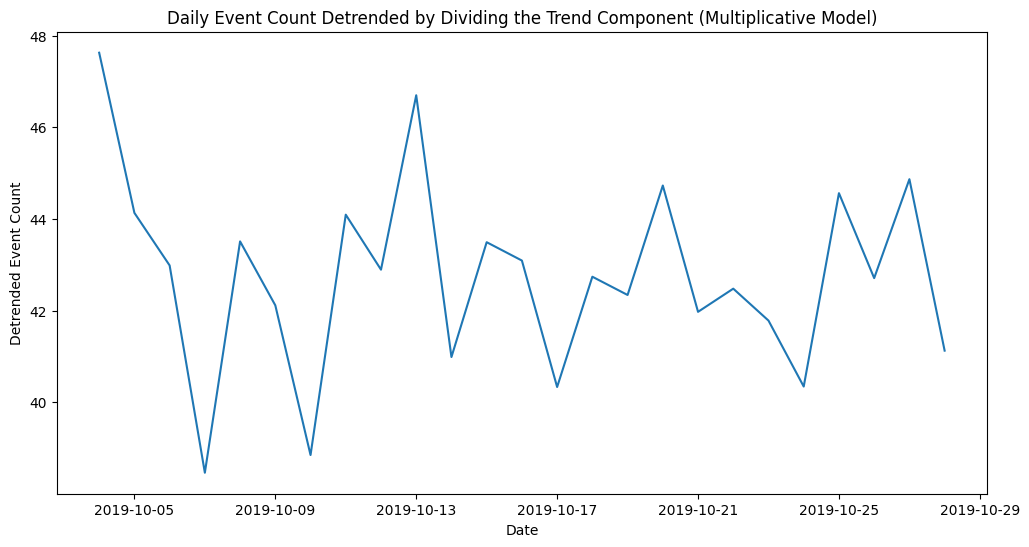

In [52]:
plt.figure(figsize=(12,6))
plt.plot(detrended)
plt.title('Daily Event Count Detrended by Dividing the Trend Component (Multiplicative Model)')
plt.xlabel('Date')
plt.ylabel('Detrended Event Count')
plt.show()

In [53]:
result_mul_seasonal = result_mul.seasonal.copy()
result_mul_seasonal.index = result_mul_seasonal.index.tz_localize(None)  # remove tz info

In [54]:
seasonally_adjusted = detrended / result_mul_seasonal

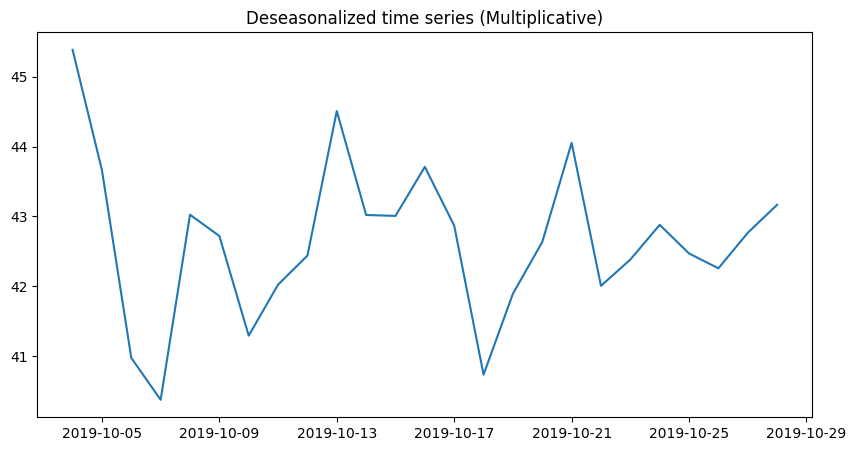

In [55]:
plt.figure(figsize=(10,5))
plt.plot(seasonally_adjusted)
plt.title('Deseasonalized time series (Multiplicative)')
plt.show()

In [56]:
result = adfuller(seasonally_adjusted.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('The deseasonalized series is stationary')
else:
    print('The deseasonalized series is not stationary')

ADF Statistic: -4.948701
p-value: 0.000028
The deseasonalized series is stationary


In [57]:
# Interpolate missing values in the deseasonalized series
seasonally_adjusted_filled = seasonally_adjusted.interpolate(method='linear')

# Double-check if any missing values remain
print(seasonally_adjusted_filled.isnull().sum())

3


In [58]:
seasonally_adjusted_filled = seasonally_adjusted_filled.dropna()
print(seasonally_adjusted_filled.isnull().sum())  # 0 now

0


In [59]:
print(len(seasonally_adjusted_filled))

28


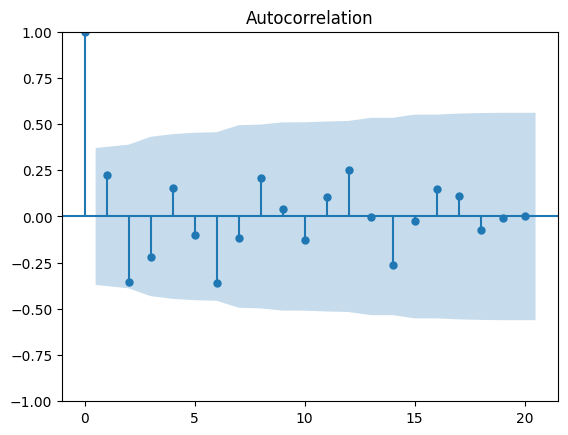

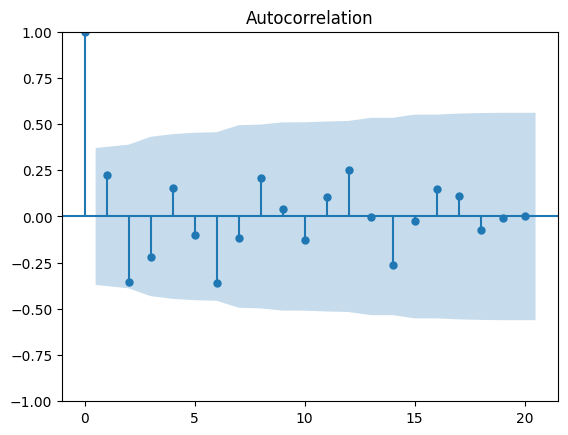

In [60]:
plot_acf(seasonally_adjusted_filled.dropna(), lags=20, ax=plt.gca())

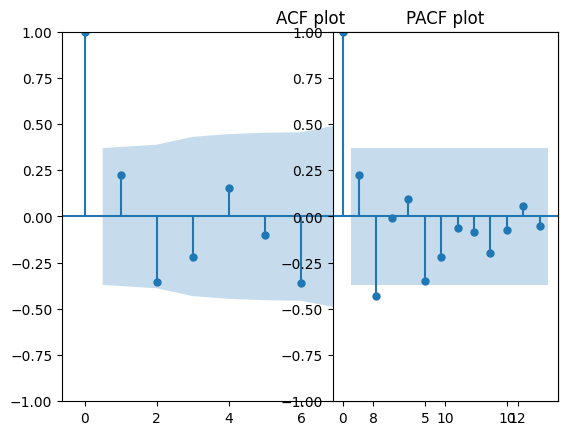

In [61]:
lags = 12  # less than 28/2
plot_acf(seasonally_adjusted_filled.dropna(), lags=lags, ax=plt.gca())
plt.title('ACF plot')

plt.subplot(1,2,2)
plot_pacf(seasonally_adjusted_filled.dropna(), lags=lags, ax=plt.gca())
plt.title('PACF plot')
plt.show()

In [ ]:
import numpy as np

df['event_type_cart'] = df['event_type_cart'].replace({1: 'cart', 0: np.nan})
df['event_type_view'] = df['event_type_view'].replace({1: 'view', 0: np.nan})  # fixed naming
df['event_type_purchase'] = df['event_type_purchase'].replace({1: 'purchase', 0: np.nan})


In [ ]:
df['event_type'] = df[['event_type_purchase', 'event_type_cart', 'event_type_view']].bfill(axis=1).iloc[:, 0]


In [ ]:
df['event_type'].unique()

In [ ]:
#drop the columns
df.drop(['event_type_cart', 'event_type_view', 'event_type_purchase'], axis=1, inplace=True)
df.head()